***Formal Simulated Inference***

We conduct hypothesis testing on specific feature columns of our data to check whether it forms clusters.

**Define Model and Assumptions:**

We assume that the data assumes a Gaussian mixture model with k components. We want to know what number of clusters/components is the most likely. Therefore, we are going to iteratively perform statistical tests on k clusters vs k+1 clusters, where k ranges from 1 to 4. 

$F_0\sim GMM(k)$

$F_A\sim GMM(k+1)$


** Formalize Statistical Test:**

We formalize it as follows:

$H_0: n = k$

$H_A: n = k+1$


**Formalize Test Statistic:**

$X = -2(\log(\lambda))$

Here, the $\lambda$ is the likelihood ratio between the alternative and the null, i.e. 

$\lambda = \frac{likelihood_A^*}{likelihood_0^*}$

The * indicates that these likelihoods are optimal. In our implementation we use an EM approach to calculate the optimal $\lambda$ using the normalmixEM method implemented within the mixtools R package.

We first proceed by writing out the necessary code:

In [1]:
#This code ingests the provided dataset, throws out columns 5 and 6, and labels the columns.

loadData <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#The data is composed of 144 columns, with each 6 consecutive columns corresponding to 1 of 24 markers. Apparently column 5 and 6 of the data are unnecessary and should be thrown out.
	#List of fluorescent markers used
	markers <- c('Synap_1', 'Synap_2', 'VGlut1_1', 'VGlut1_2', 'VGlut2', 'VGlut3', 'PSD', 'Glur2', 'NDAR1', 'NR2B', 'GAD', 'VGAT', 'PV',
	'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'Tubuli', 'DAPI')
	
	#What columns 1-4 for each of the florescent markers coorespond to.
	labels <- c('Int_Bright','Local_Bright','Dist_COM','MOI')
	
	#Generate labels for each column
	col_labels <- c() 
	
	for (i in 1:length(markers)){
		for (j in 1:length(labels)){
			col_labels[(i - 1) * length(labels) + j] = paste(markers[i],"_",labels[j],sep = "")
		}
	}
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data <- fread("synapsinR_7thA.tif.Pivots.txt.2011Features.txt")

	#Convert to dataframe
	data <- as.data.frame(data)

	#Remove columns 5 and 6 corresponding to each fluorescent marker
	good_ones <- c(1:dim(data)[2])
	dim(good_ones) <- c(6,dim(data)[2] / 6)
	good_ones <- good_ones[1:4,]
	dim(good_ones) <- c(4 * dim(good_ones)[2],1)
	data_cleaned <- data[,good_ones]
	
	#Label data
	colnames(data_cleaned) <- col_labels
	
	return(data_cleaned)
}

In [2]:
#Subsamples 10000 rows from the original data set for easier analysis

subsampleRows <- function(data,samples = 10000,seed = 42){
	#Subsample some number of rows for further analysis. Set seed for reproducibility.
	set.seed(seed);rand_rows = sample(1:dim(data)[1],samples)
	subsample <- data[rand_rows,]
	return(subsample)
}

In [4]:
#Wrapper of gmm.test and gmm.power code provided by Jovo. Conducts hypothesis test of H_0 = n gaussians vs H_a = n+1 gaussians for n = 1:maxK and constructs power curves for univariate data.


marginal_inference <- function(data,maxK = 3, nboot = 10, power = TRUE){
	require(data.table)
	require(ggplot2)
	require(gtable)
	require(subspace)
	require(mixtools)

	#' Testing Routine for GMM 
	#' 
	#' @param Xdata Univariate data
	#' @param maxK The upper bound on the number of components
	#' @param nboot The number of bootstrap replicates to be used 
	#' @return 
	#' 
	#' 

	require(foreach)
	gmm.test <- function(Xdata,maxK=3,nboot=10) {
	  nsample = length(Xdata)
	  
	  foreach(nK=1:maxK,.errorhandling = 'remove') %do% {
		fit.null = go.fit(Xdata,k=nK)
		fit.alt  = go.fit(Xdata,k=nK+1)
		my.stat = -2 * (fit.alt$loglik - fit.null$loglik)
		boot.dist.null = foreach(itr=1:nboot,.combine='c',.errorhandling = 'remove') %do% {
		  Xboot = go.sim(nsample = nsample, param = fit.null,k = nK)
		  fit.null.boot = go.fit(Xboot,k=nK)
		  fit.alt.boot = go.fit(Xboot,k=nK+1)
		  -2 * (fit.alt.boot$loglik - fit.null.boot$loglik)
		}
		
		my.ecdf = ecdf(boot.dist.null)
		list(nK=nK, fitted=fit.null, stat=my.stat, pval= my.ecdf(my.stat))
	  }
	}

	#' Power calculation routine for GMM 
	#' 
	#' @param nullparam 
	#' @param altparam
	#' @param alpha
	#' @param maxmc
	#' @return
	#' 
	gmm.power <- function(nsample,nullK, altK, nullparam, altparam, alpha=0.05, maxmc = 10) {
	  boot.dist.null = foreach(itr=1:maxmc,.combine='c',.errorhandling = 'remove') %do% {
		Xboot = go.sim(nsample,nullparam,nullK)
		fit.null.boot = go.fit(Xboot,k = nullK)
		fit.alt.boot = go.fit(Xboot,k=altK)
		-2 * (fit.alt.boot$loglik - fit.null.boot$loglik)
	  }
	  
	  boot.dist.alt = foreach(itr=1:maxmc,.combine='c',.errorhandling = 'remove') %do% {
		Xboot = go.sim(nsample,altparam, altK)
		fit.null.boot = go.fit(Xboot,k = nullK)
		fit.alt.boot = go.fit(Xboot,k=altK)
		-2 * (fit.alt.boot$loglik - fit.null.boot$loglik)
	  }
	  
	  cval = quantile(boot.dist.null,alpha)
	  power_alt <- ecdf(boot.dist.alt)(cval)
	  power_null <- ecdf(boot.dist.null)(cval)
	  c(power_alt,power_null)
	  
	}

	go.fit <- function(Xdata,k) {
	  if(k> 1) {
		normalmixEM(Xdata,k=k)
	  } else {
		list(mean=mean(Xdata),sd=sd(Xdata),loglik=sum(log(dnorm(Xdata,mean=mean(Xdata),sd=sd(Xdata)))))
	  }
	}

	go.sim <- function(nsample,param,k) {
	  if(k > 1) {
		rnormmix(nsample, lambda=param$lambda, mu=param$mu, sigma =param$sigma)
	  } else {
		rnorm(nsample,mean=param$mean,sd=param$sd)
	  }
	}
	
	test_result <- gmm.test(data,maxK,nboot)
	power_curve <-c()
	if (power){
		domain <- 20 * c(1:25)
		temp <- cbind(rep(0,25),rep(0,25))
		power_curve <- domain
		for (i in c(1:(maxK - 1))){
			for (j in c(1:25)){
				temp[j,] <- gmm.power(nsample = domain[j],nullK = i, altK = i + 1,nullparam = test_result[[i]]$fitted, altparam = test_result[[i + 1]]$fitted,maxmc = nboot)
			}
			power_curve <- cbind(power_curve,temp)
			colnames(power_curve)[2 * i] <- paste(i,"versus",i + 1,"H_a",sep="")
			colnames(power_curve)[2 * i + 1] <- paste(i,"versus",i + 1,"H_0",sep="")
		}
		colnames(power_curve)[1] <- "Samples"
		power_curve <- as.data.frame(power_curve)
	}
	result <- list(test_result,power_curve)
}

In [5]:
#Driver funciton for marginal_inference. Feeds individual columns from input data to marginal_inference to conduct hypothesis tests.

conductInference <- function(data,maxK = 3, nboot = 10, power = TRUE, columns_to_analyze = 4 * c(0:23) + 1){
	require(ggplot2)
	require(reshape)
	
	plots <- list()
	tests_to_run <- c()
	for (i in 1:maxK - 1){
		tests_to_run[i] <- paste("k =",i,"versus k =",i + 1)
	}
	
	for (i in columns_to_analyze){
		capture.output(test_result <- marginal_inference(data[,i],maxK = maxK, nboot = nboot, power = power),file = "NUL")
		pvals <- rep(-1,maxK-1)
		test <- test_result[[1]]
		power_curve <- test_result[[2]]
		p1 <- list()
		colnames(power_curve)[2:length(colnames(power_curve))] <- paste("c",c(2:length(power_curve)),sep="")
		for (j in c(1:(maxK - 1))){
			df <- power_curve[,c(1,2 * j, 2 * j + 1)]
			df <- melt(df,"Samples")
			p1[[j]] <- ggplot(df,aes_string(x = "Samples", y = "value", color = "variable")) + geom_point() + xlab("Samples") + ylab("Power") + ggtitle(paste("Power for test of k =",j,"versus k =",j + 1)) + scale_colour_manual("Distribution",values = c("blue","red"),labels=c("Alt", "Null"))
			print(p1[[j]])
			pvals[j] <- test[[j]]$pval		
		}	
		pval_df <- as.data.frame(cbind(tests_to_run,pvals))
		p2 <- ggplot(pval_df,aes(x = tests_to_run, y = pvals)) + geom_point() + xlab("Test") + ylab("P-value") + ggtitle("Inference Testing Results")
		print(p2)
		plots <- list(plots, p1,p2)
		
	}
	
	return(plots)
}

We load in the required data:

In [6]:
data <- loadData()

Loading required package: data.table
Warning message:
: package 'data.table' was built under R version 3.1.3

Read 1119299 rows and 144 (of 144) columns from 1.817 GB file in 00:04:30


We then subsample 300 samples. Note that this is sufficient, as we will test up to k = 6, which means that the largest gaussian mixture model that we will need to fit (recall that we are testing on univariate data) will have 6+6+(6-1) = 23 degree of freedom. Hence, we have over 10 data points for each degree of freedom. 

In [8]:
subsample <- subsampleRows(data,300)

We are now ready to conduct our hypothesis testing. Note that the gmm.power function nested within the marginal_inference function samples data from the null and alternative distribution and plots the power curves. The gmm.test function nested within the marginal_inference funciton then conducts the test on the input data. the conductInference funciton acts as a driver function which takes output from the marginal_inference function and plots it via the ggplot2 package in R. We will first get a general feel for our test by using the synapsin integrated brightness column. As this is just a proof of concept, we will do a small number of bootstraps (in this case 20).

Loading required package: ggplot2
Loading required package: reshape
Loading required package: gtable
Warning message:
: package 'gtable' was built under R version 3.1.3Loading required package: grid
Loading required package: subspace
Warning message:
: package 'subspace' was built under R version 3.1.3Loading required package: mixtools
Warning message:
: package 'mixtools' was built under R version 3.1.3Loading required package: boot
Loading required package: MASS
Loading required package: segmented
Warning message:
: package 'segmented' was built under R version 3.1.3mixtools package, version 1.0.3, Released 2015-04-18
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.


Attaching package: 'mixtools'

The following object is masked from 'package:grid':

    depth

Loading required package: foreach
Warning message:
: package 'foreach' was built under R version 3.1.3

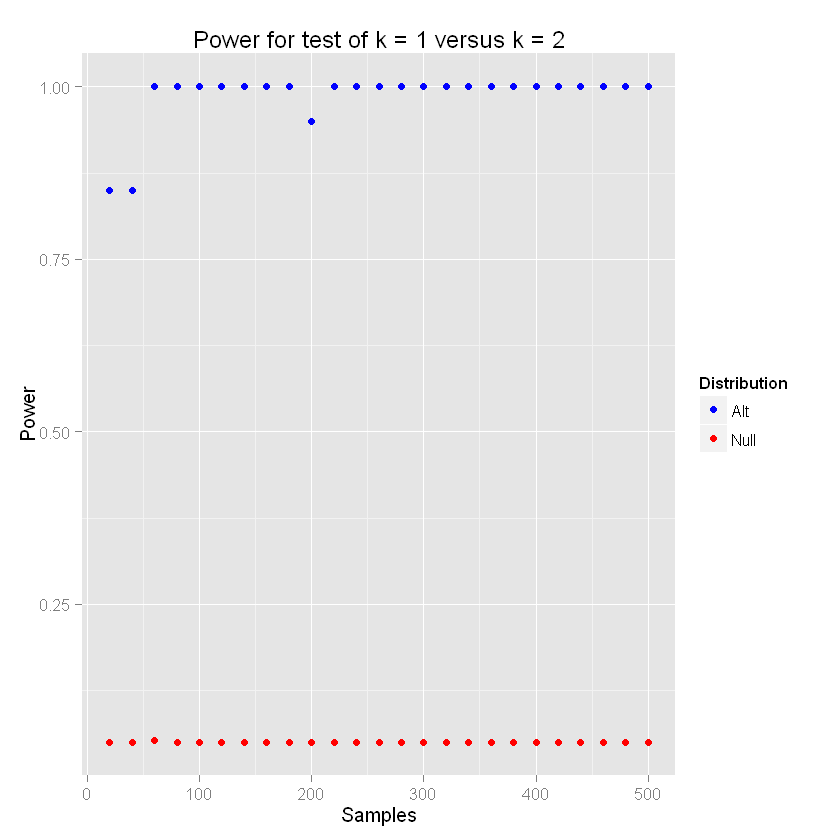

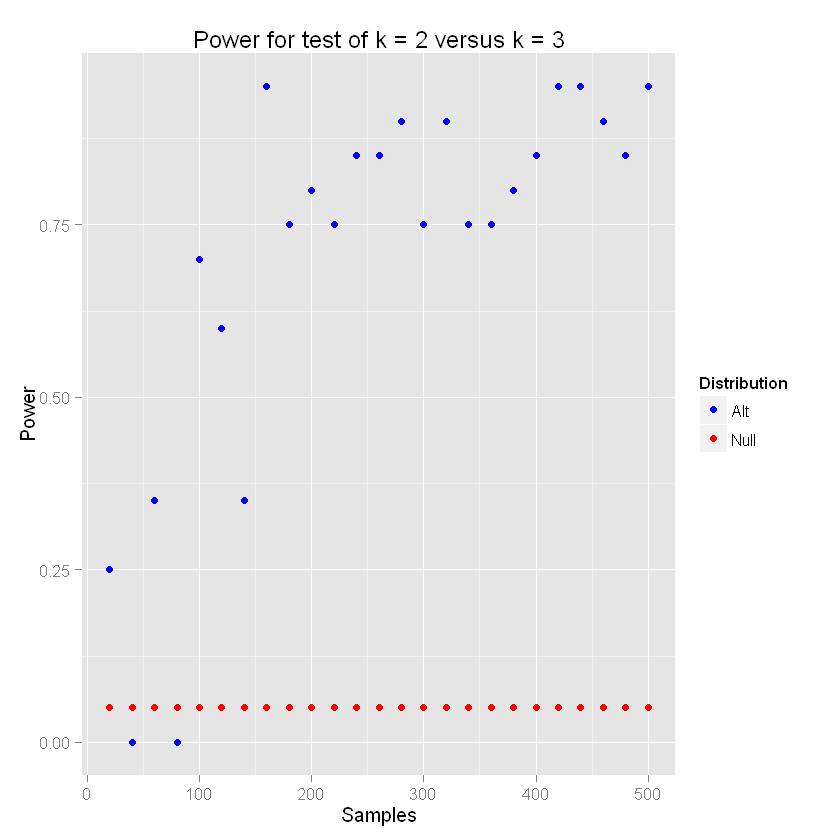

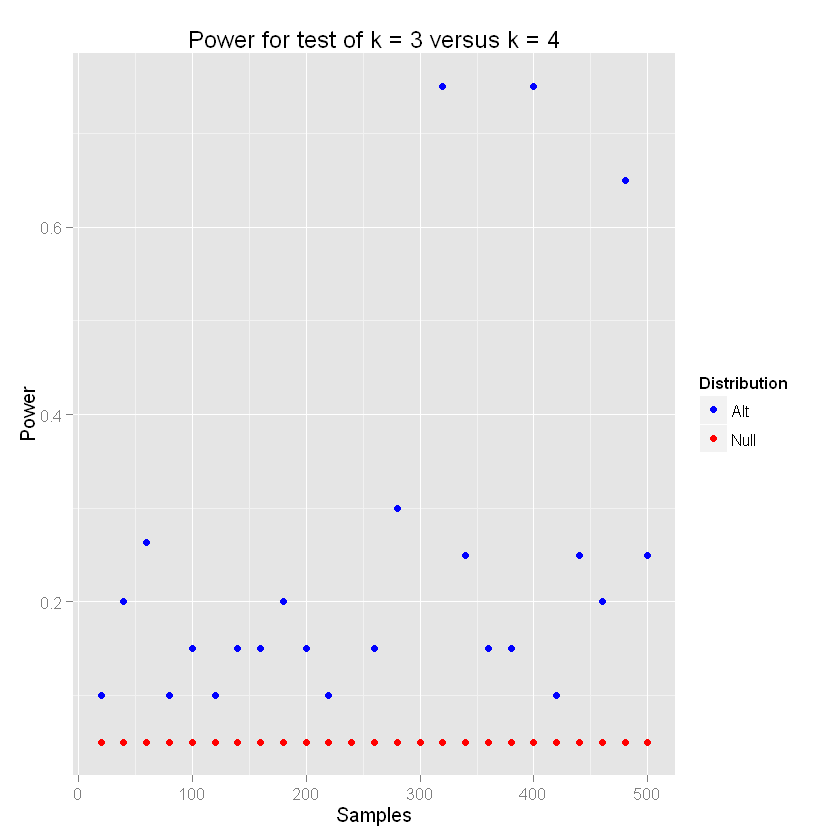

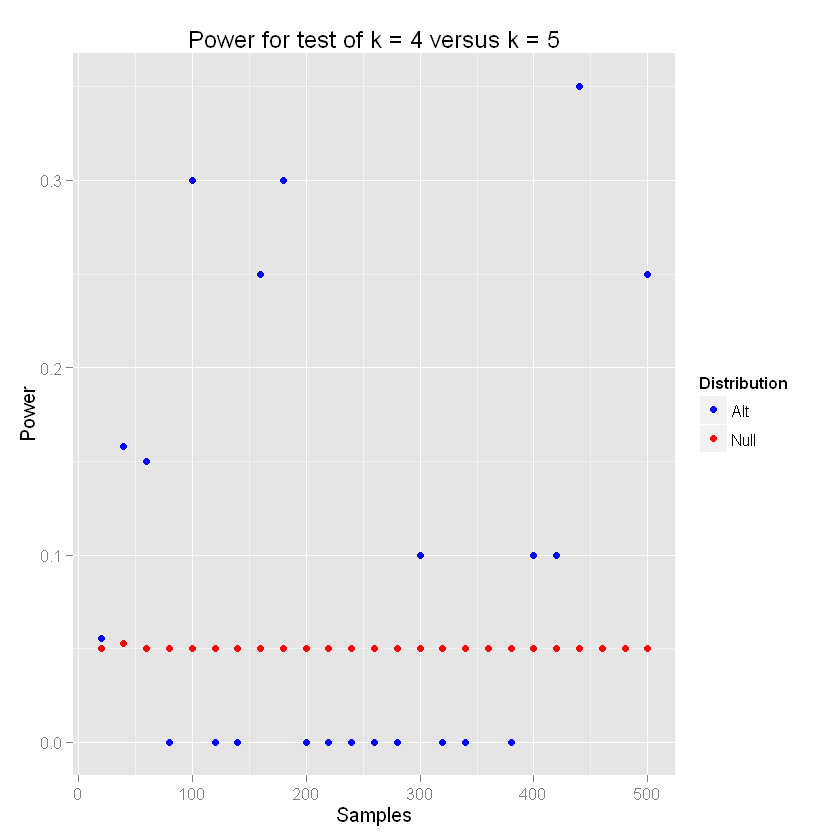

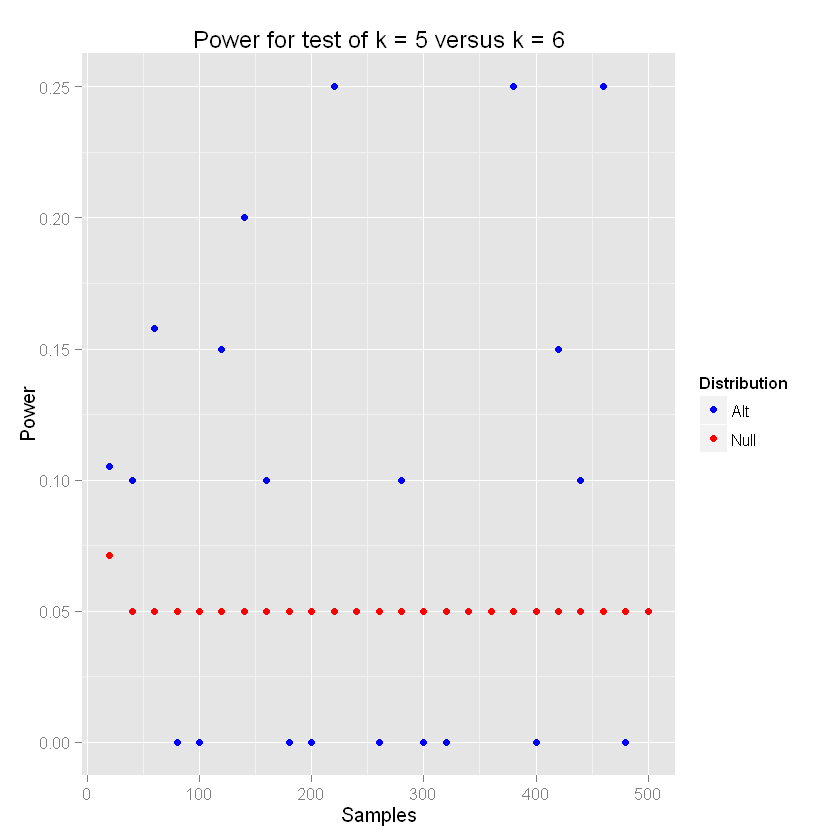

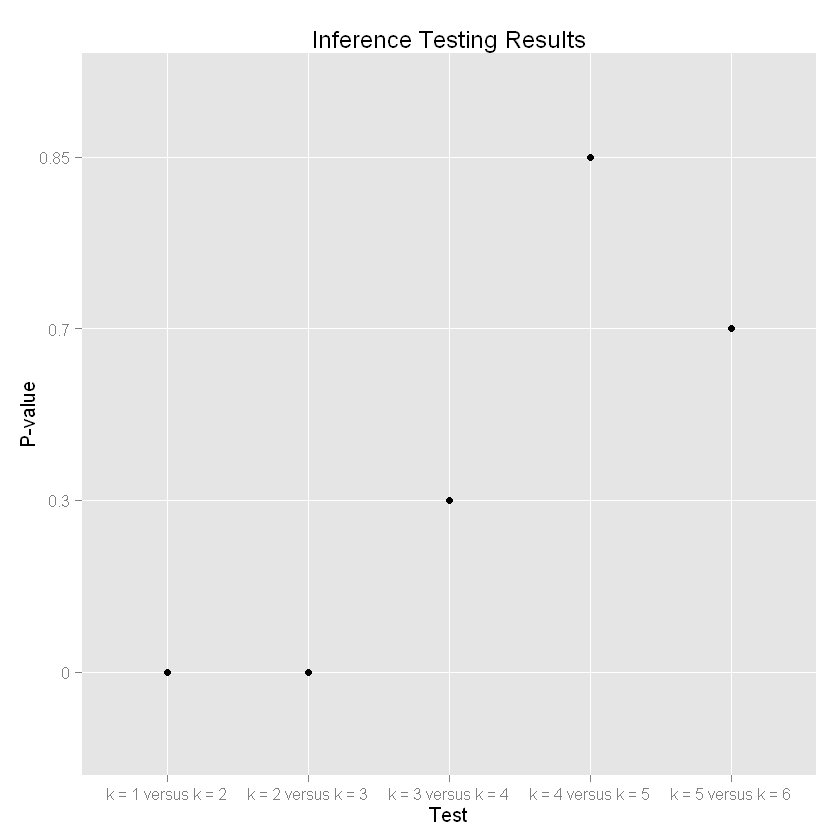

In [10]:
r1 <- conductInference(subsample,maxK = 6, nboot = 20, power = TRUE, columns_to_analyze = 1)

It looks pretty good, considering the low number of bootstraps. Let us do something more interesting by looking at the VGlut1 integrated brightness column with 100 bootstraps.

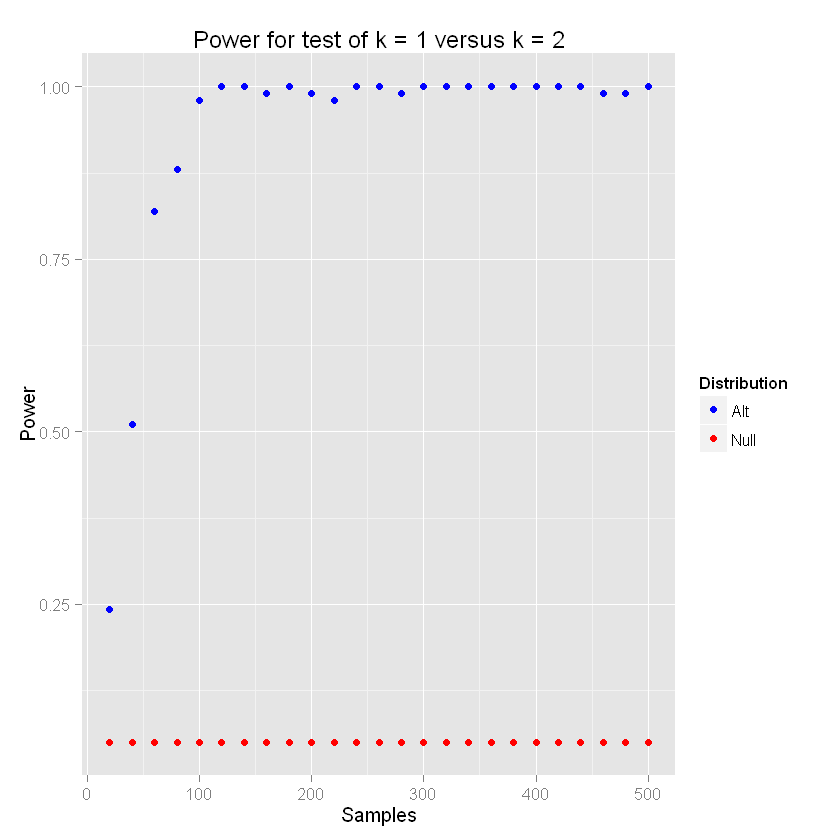

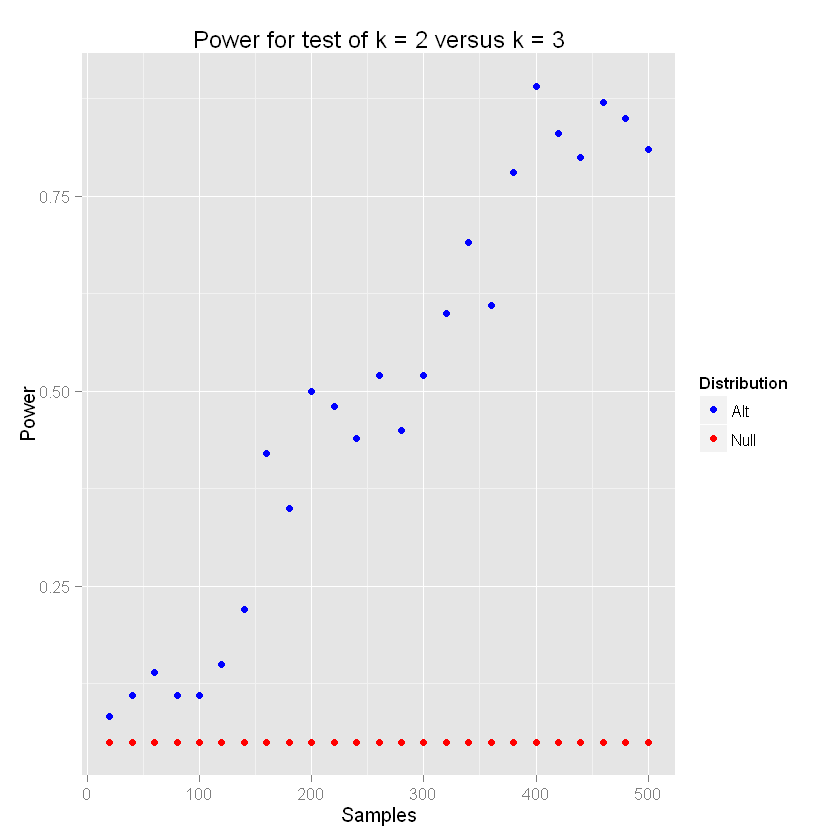

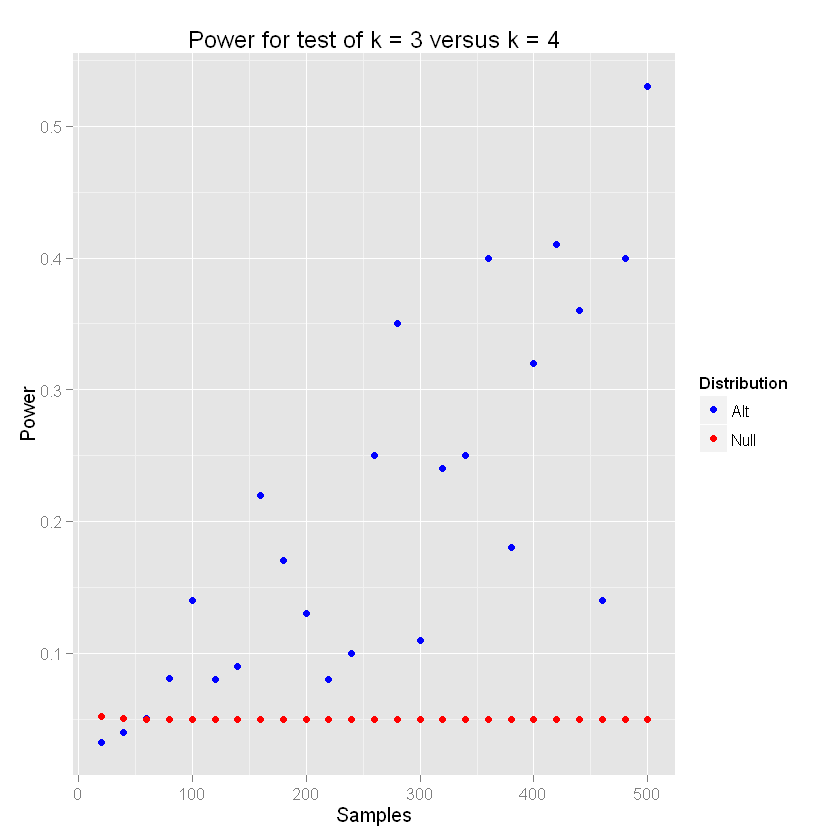

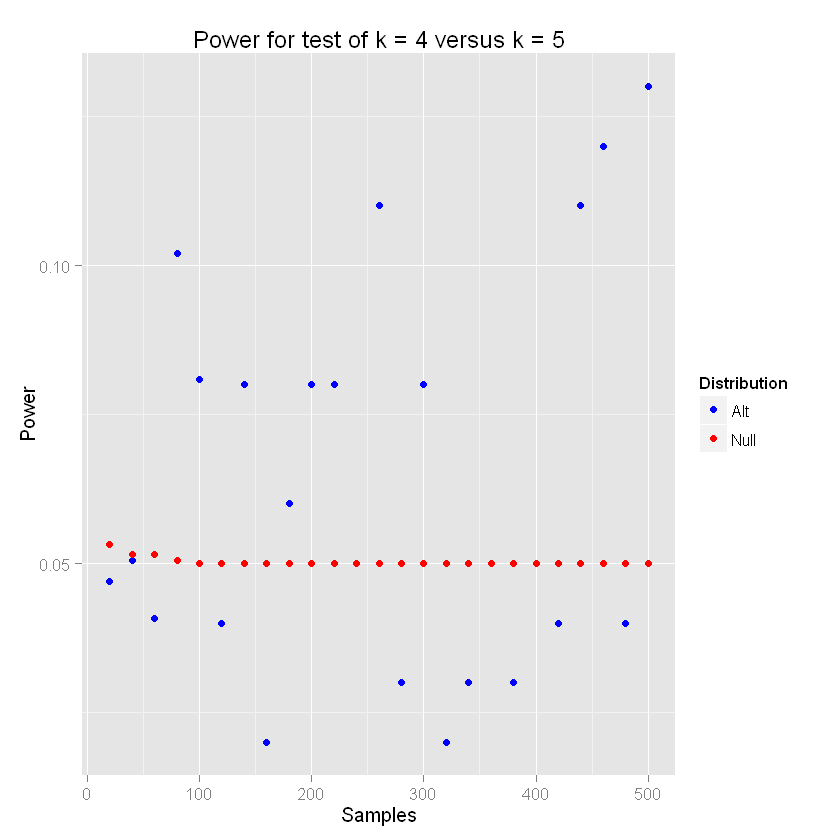

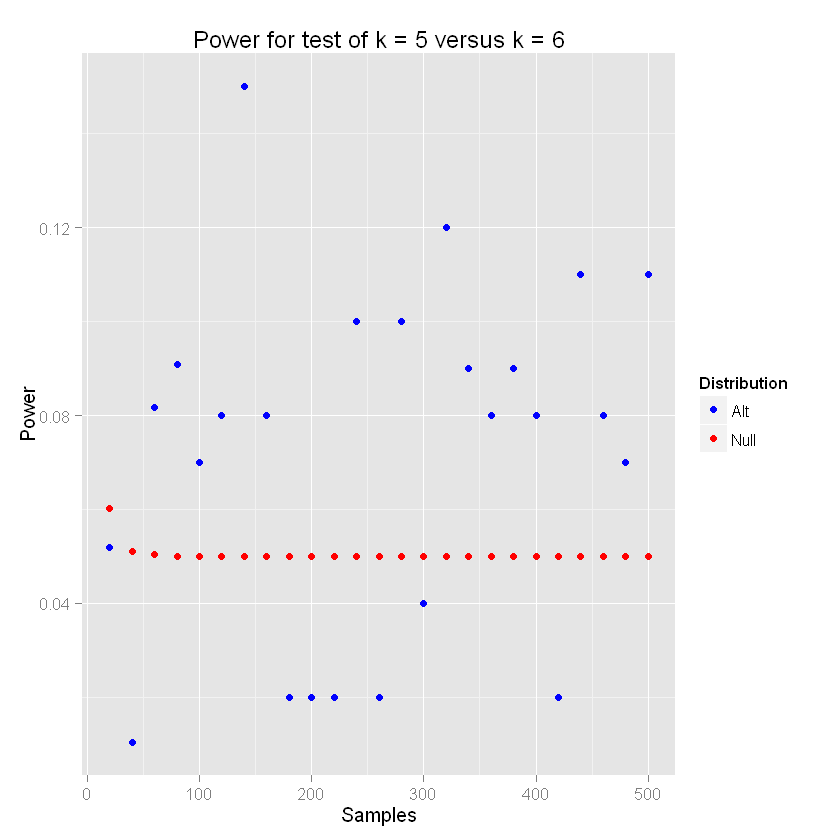

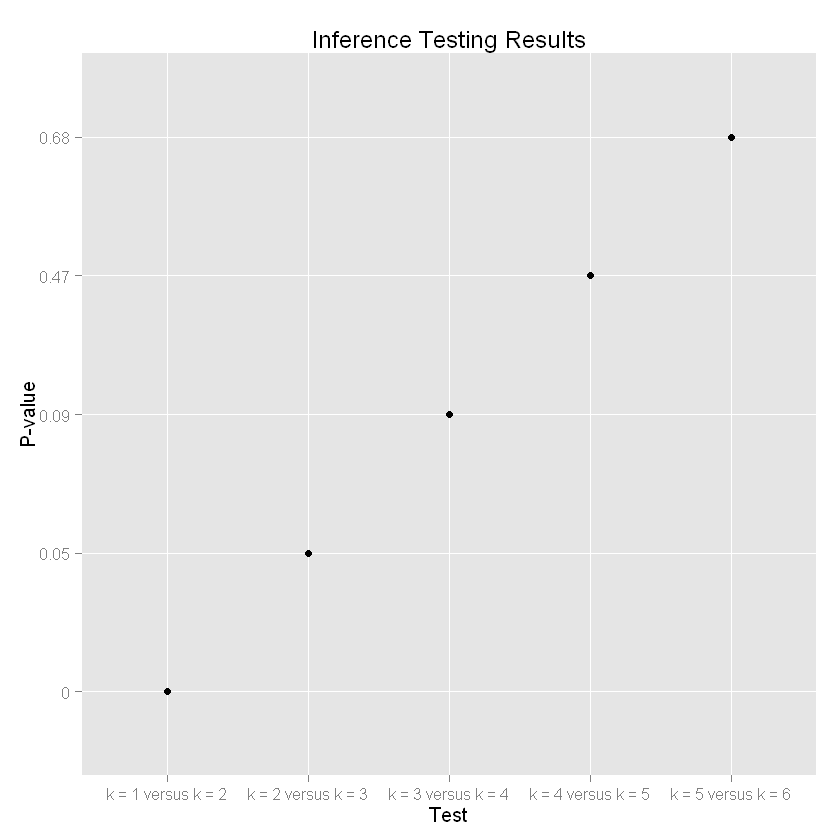

In [11]:
r2 <- conductInference(subsample,maxK = 6, nboot = 100, power = TRUE, columns_to_analyze = 9)

**Reflect:**

The tests definately suggest the the Synapsin integrated brightness and VGlut1 integrated brightness columns cluster.